# 非階層的クラスタリング

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anim
from sklearn import datasets
from IPython.display import HTML

$\def\bm{\boldsymbol}$[ビッグ・ファイブ](https://ja.wikipedia.org/wiki/%E3%83%93%E3%83%83%E3%82%B0%E3%83%95%E3%82%A1%E3%82%A4%E3%83%96_(%E5%BF%83%E7%90%86%E5%AD%A6))理論によると、人間のパーソナリティは、開放性（openness to experience）、勤勉性（conscientiousness）、外向性（extraversion）、協調性（agreeableness）、神経症傾向（neuroticism）の５つ因子の組み合わせで表現できるという。この理論に基づくパーソナリティ診断の質問票が開発されている。

+ [Big Five Personality Test (IPIP Big-Five Factor Markers)](https://openpsychometrics.org/tests/IPIP-BFFM/) {cite}`Goldberg:92`
+ [TIPI日本語版](http://www.f.waseda.jp/oshio.at/research/scales/TIPI-J.pdf) {cite}`Kojio:12`

以下のセルにTIPI-Jによるパーソナリティ診断を実装した（プログラムを読まずに動かしてみるとよい）。

In [3]:
S = """あなた自身にどのくらい当てはまるか、７段階で答えてください。
    1: 全く違うと思う
    2: おおよそ違うと思う
    3: 少し違うと思う
    4: どちらでもない
    5: 少しそう思う
    6: まあまあそう思う
    7: 強くそう思う
"""

A = [
    ["活発で、外向的だと思う", 0],
    ["他人に不満をもち、もめごとを起こしやすいと思う", 0],
    ["しっかりしていて、自分に厳しいと思う", 0],
    ["心配性で、うろたえやすいと思う", 0],
    ["新しいことが好きで、変わった考えをもつと思う", 0],
    ["ひかえめで、おとなしいと思う", 0],
    ["人に気をつかう、やさしい人間だと思う", 0],
    ["だらしなく、うっかりしていると思う", 0],
    ["冷静で、気分が安定していると思う", 0],
    ["発想力に欠けた、平凡な人間だと思う", 0],
]


def tipij(A):
  v = [a[1] for a in A]
  return {
      '外向性': (v[0] + (8 - v[5])) / 2,
      '協調性': ((8 - v[1]) + v[6]) / 2,
      '勤勉性': (v[2] + (8 - v[7])) / 2,
      '神経症傾向': (v[3] + (8 - v[8])) / 2,
      '開放性': (v[4] + (8 - v[9])) / 2
  }


print(S, end='')
for a in A:
  a[1] = int(input(a[0]))
tipij(A)


あなた自身にどのくらい当てはまるか、７段階で答えてください。
    1: 全く違うと思う
    2: おおよそ違うと思う
    3: 少し違うと思う
    4: どちらでもない
    5: 少しそう思う
    6: まあまあそう思う
    7: 強くそう思う


{'外向性': 6.0, '協調性': 2.5, '勤勉性': 2.5, '神経症傾向': 2.0, '開放性': 4.0}

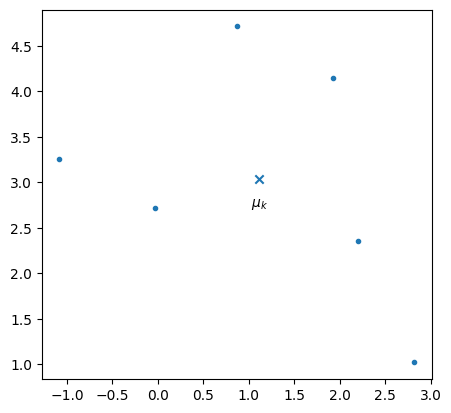

In [4]:
X, y = datasets.make_blobs(n_samples=6, random_state=0)
mu = X.mean(axis=0)

fig, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], marker='.', color='tab:blue')
ax.scatter([mu[0]], [mu[1]], marker='x', color='tab:blue')
ax.text(mu[0], mu[1]-0.3, '$\mu_k$', ha='center')
ax.set_aspect('equal')
plt.show()


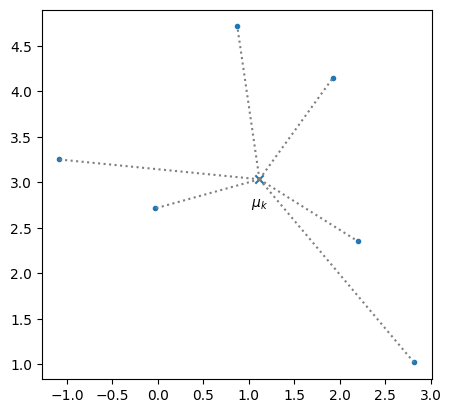

In [5]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], marker='.', color='tab:blue')
ax.scatter([mu[0]], [mu[1]], marker='x', color='tab:blue')
ax.text(mu[0], mu[1]-0.3, '$\mu_k$', ha='center')
for i in range(len(X)):
  ax.plot([mu[0], X[i][0]], [mu[1], X[i][1]], ls=':', color='tab:gray')
ax.set_aspect('equal')
plt.show()


In [6]:
X, y = datasets.make_blobs(n_samples=12, random_state=0)
X = np.fliplr(X) # Flipping x0 and x1 makes the visualization beautiful.

このデータを$xy$平面上にプロットする。

In [7]:
def initialize_plot(ax, X, has_message=True):
  d = 1.5 if has_message else 1.
  ax.set_xlim(X[:, 0].min()-1, X[:, 0].max()+1)
  ax.set_ylim(X[:, 1].min()-d, X[:, 1].max()+1)
  ax.set_aspect('equal')


def draw_kmeans(ax, X, y=None, centers=None, wcss=None, msg='', arrowstyle='-'):

  def get_annotation_position(p, center, dist=0.5):
    delta = p - center
    delta /= np.linalg.norm(delta)
    return p + delta * dist

  artist = []
  center = X.mean()

  # Draw data points.
  colors = y if y is not None else 'black'
  artist.append(ax.scatter(X[:, 0], X[:, 1], c=colors, marker='.'))

  # Draw cluster centers.
  if centers is not None:
    artist.append(ax.scatter(centers[:, 0], centers[:, 1], marker='x', c=range(len(centers))))

  # Draw cluster IDs.
  if centers is not None:
    for i, mu in enumerate(centers):
      p = get_annotation_position(mu, center)
      artist.append(ax.text(p[0], p[1], f'{i+1}', ha='center', va='center'))

  # Draw dotted lines between cluster centers and members.
  if centers is not None and y is not None:
    for i, x in enumerate(X):
      cid = y[i]
      artist.append(
          ax.annotate(
              '', xy=x, xytext=centers[cid],
              arrowprops=dict(
                  arrowstyle=arrowstyle,
                  linestyle="--",
                  shrinkA=0,
                  shrinkB=0,
                  color='tab:gray'
              )
          )
      )

  # Draw the message.
  if msg:
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    artist.append(ax.text(xmin+0.2, ymin+0.2, msg))

  return artist


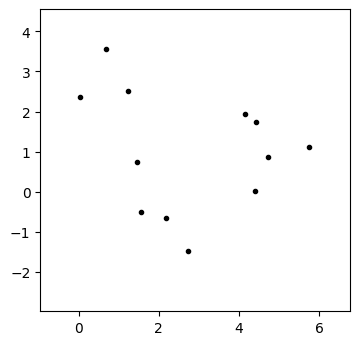

In [7]:
fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)
draw_kmeans(ax, X)
plt.show()

In [9]:
def kmeans(X, num_clusters, max_iterations=1000, seed=0, H=None):
  n, d = X.shape
  wcss = 0.
  y = np.zeros(n, dtype=int)
  y_old = None

  # Prepare a random generator with the seed.
  rng = np.random.default_rng(seed)

  # Extract K points at random from the data as the initial centers.
  centers = X[rng.permutation(n)[:num_clusters]]

  for t in range(max_iterations):
    wcss = 0.

    # Record the cluster centers (used only for visualizing the progress).
    if H is not None:
      H.append([t, 'center', centers.copy()])

    # Find cluster assignments.
    for i in range(n):
      # Compute the distance to each cluster center.
      dist = ((X[i] - centers) ** 2).sum(1)
      # Assign the id of the closest cluster.
      y[i] = np.argmin(dist)
      wcss += dist[y[i]]

    # Record the cluster assignments and WCSS (used only for visualizing the progress).
    if H is not None:
      H.append([t, 'assign', wcss, y.copy()])

    # Terminate if the cluster assignement was unchanged.
    if np.all(y == y_old):
      break

    # Compute the geometric center of each cluster.
    for c in range(num_clusters):
      indices = np.where(y == c)       # i such that Y[i] == c
      centers[c] = X[indices].mean(0)

    # Store the current cluster assignment for the next iteration.
    y_old = y.copy()

  return y, centers, wcss


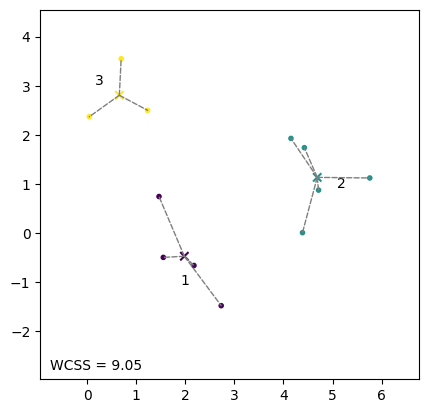

In [10]:
num_clusters = 3
seed = 8
y_pred, centers, wcss = kmeans(X, num_clusters, seed=seed)

fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)
draw_kmeans(ax, X, y_pred, centers, msg=f'WCSS = {wcss:.2f}')
plt.show()


In [11]:
H = []
seed = 8
final_y, final_centers, final_wcss = kmeans(X, num_clusters, seed=seed, H=H)

fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)

artists = []
y = None
centers = None

artists.append(draw_kmeans(ax, X, y, centers, msg='Data points to be clustered'))

for h in H:
  t, event, args = h[0], h[1], h[2:]
  if event == 'center':
    centers = args[0]
    if t == 0:
      msg = f'Iter {t+1}: initialize centers at random'
    else:
      msg = f'Iter {t+1}: update centers from members'
    artists.append(draw_kmeans(ax, X, y, centers, arrowstyle='<-', msg=msg))
  elif event == 'assign':
    wcss, y = args
    msg = f'Iter {t+1}: update members (WCSS={wcss:.2f})'
    artists.append(draw_kmeans(ax, X, y, centers, arrowstyle='->', msg=msg))

msg = f'Final result (WCSS={final_wcss:.2f})'
artists.append(draw_kmeans(ax, X, final_y, final_centers, arrowstyle='-', msg=msg))

ani = anim.ArtistAnimation(fig, artists, interval=2000)
html = ani.to_jshtml()
plt.close(fig)
HTML(html)


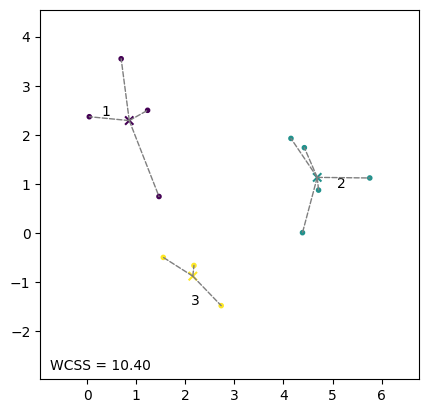

In [12]:
seed = 0
y_pred, centers, wcss = kmeans(X, num_clusters, seed=seed)

fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)
draw_kmeans(ax, X, y_pred, centers, msg=f'WCSS = {wcss:.2f}')
plt.show()


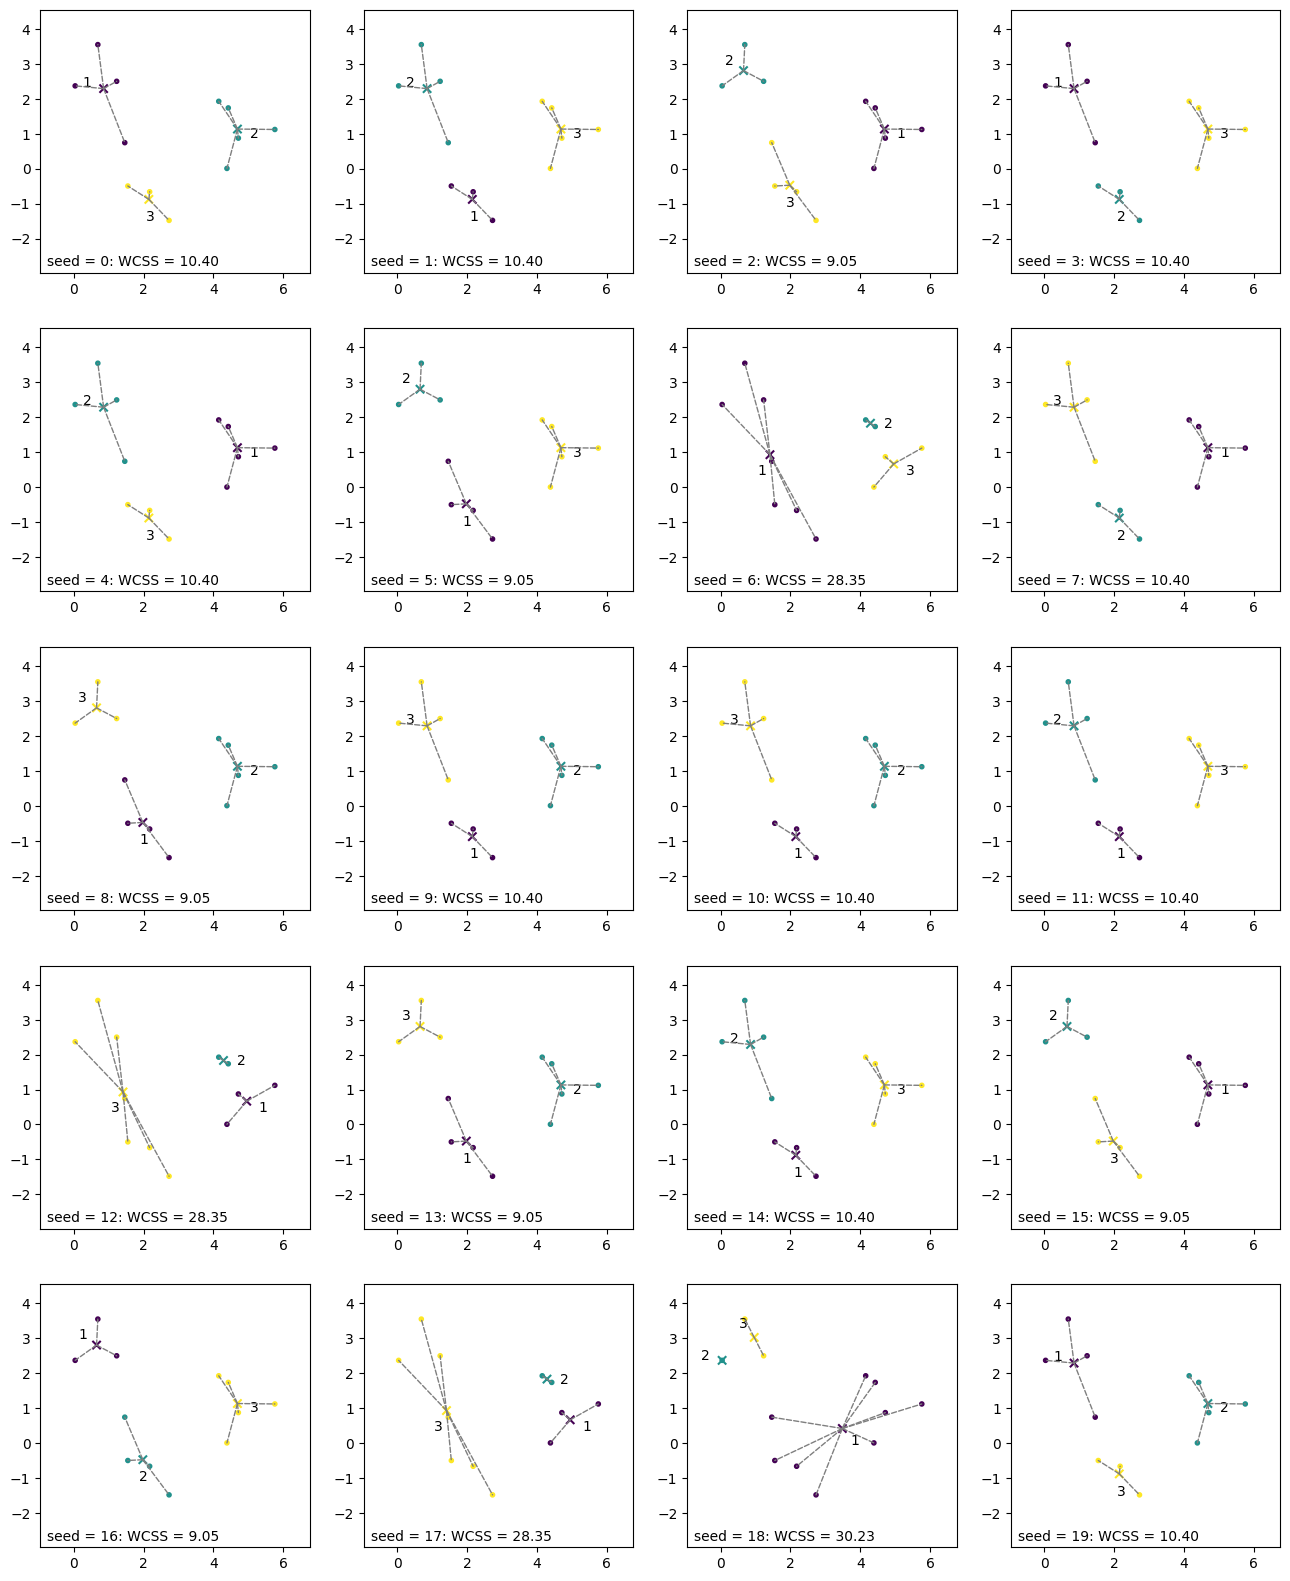

In [13]:
fig, axs = plt.subplots(5, 4, dpi=100, figsize=(16, 20))

for i in range(20):
  ax = axs[i // 4][i % 4]
  initialize_plot(ax, X)
  y_pred, centers, wcss = kmeans(X, num_clusters, seed=i)
  draw_kmeans(ax, X, y_pred, centers, msg=f'seed = {i}: WCSS = {wcss:.2f}')
plt.show()


/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


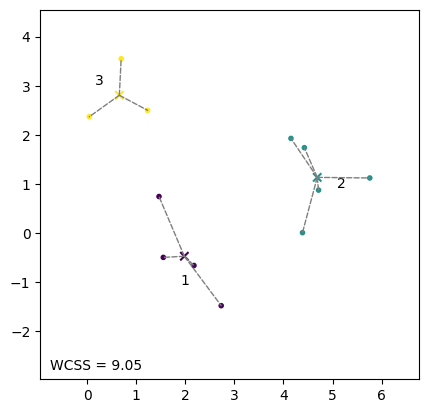

In [14]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(X)
y_pred = model.labels_

fig, ax = plt.subplots(dpi=100)
initialize_plot(ax, X)
draw_kmeans(ax, X, y_pred, model.cluster_centers_, msg=f'WCSS = {model.inertia_:.2f}')
plt.show()


/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/bu

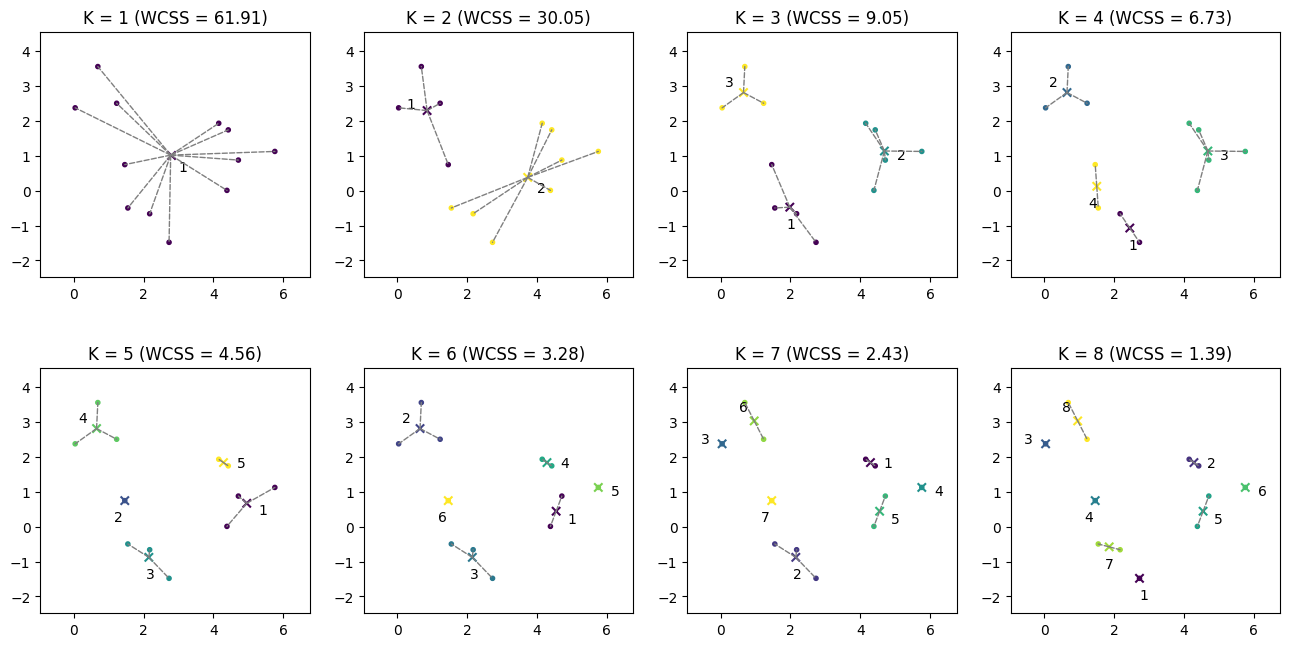

In [16]:
fig, axs = plt.subplots(2, 4, dpi=100, figsize=(16, 8))

J = []
for n in range(0, 8):
  num_clusters = n+1

  model = KMeans(n_clusters=num_clusters)
  model.fit(X)
  y_pred = model.labels_
  J.append(model.inertia_)

  ax = axs[n // 4][n % 4]
  initialize_plot(ax, X, has_message=False)
  ax.set_title(f'K = {num_clusters} (WCSS = {model.inertia_:.2f})')
  draw_kmeans(ax, X, y_pred, model.cluster_centers_)

plt.show()


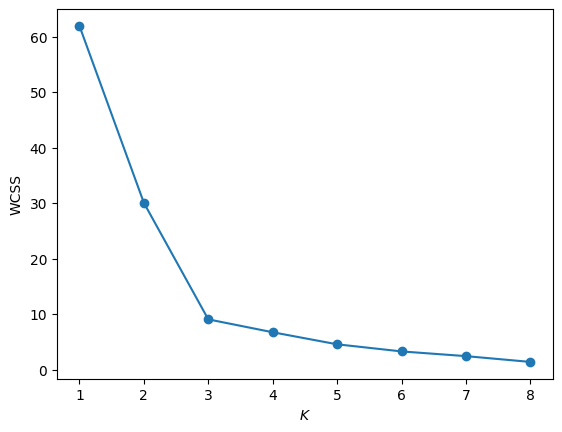

In [17]:
fig, ax = plt.subplots(dpi=100)
ax.plot(list(range(1, 9)), J, 'o-')
ax.set_xlabel('$K$')
ax.set_ylabel('WCSS')
plt.show()


In [18]:
num_clusters = 3
model = KMeans(n_clusters=num_clusters)
model.fit(X)
y_pred = model.labels_
centers = model.cluster_centers_

/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


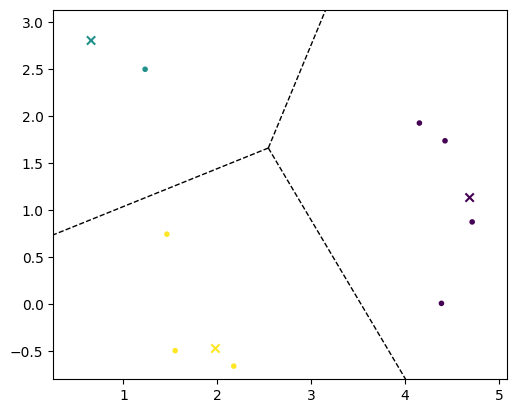

In [19]:
from scipy.spatial import Voronoi, voronoi_plot_2d

fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.scatter(X[:, 0], X[:, 1], c=y_pred, marker='.')
ax.scatter(centers[:, 0], centers[:, 1], marker='x', c=range(num_clusters))

vor = Voronoi(centers)
voronoi_plot_2d(vor, ax, show_points=False, show_vertices=False)

plt.show()


/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


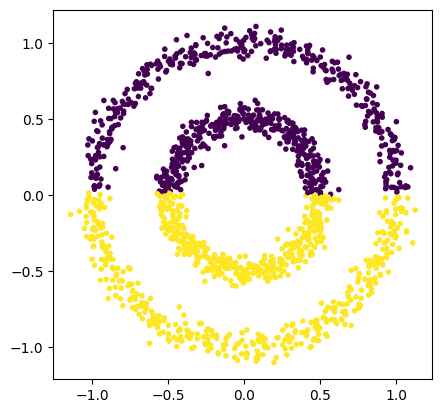

In [21]:
X, y = datasets.make_circles(n_samples=1500, factor=.5, noise=.05)
model = KMeans(n_clusters=2)
model.fit(X)

fig, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], c=model.labels_, marker='.')
ax.set_aspect('equal')
plt.show()


/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


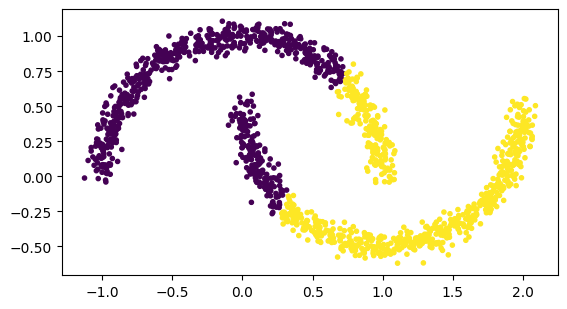

In [22]:
X, y = datasets.make_moons(1500, noise=.05)
model = KMeans(n_clusters=2)
model.fit(X)

fig, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], c=model.labels_, marker='.')
ax.set_aspect('equal')
plt.show()


/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


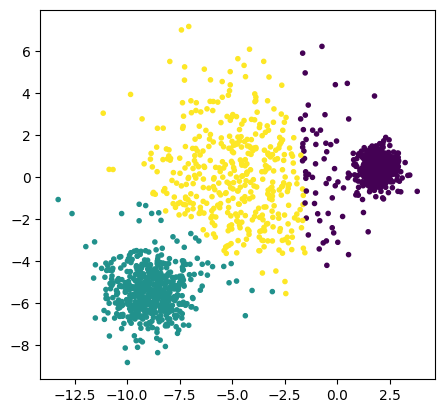

In [23]:
X, y = datasets.make_blobs(1500, cluster_std=[1.0, 2.5, 0.5], random_state=170)
model = KMeans(n_clusters=3)
model.fit(X)

fig, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], c=model.labels_, marker='.')
ax.set_aspect('equal')
plt.show()


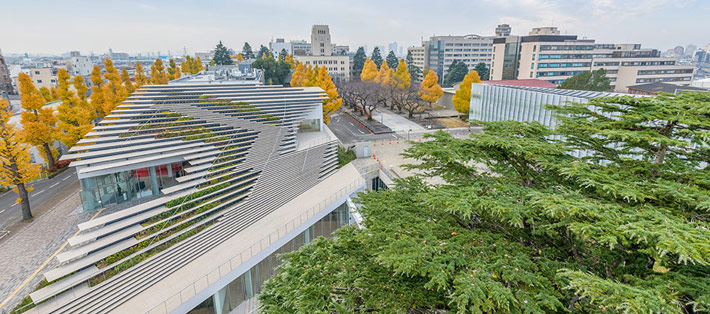

In [24]:
import io
import requests
from PIL import Image

img = Image.open(io.BytesIO(requests.get(
    "https://www.titech.ac.jp/news/img/news-26569-title.jpg").content))
img


In [25]:
m = np.array(img)


In [26]:
m.shape

(314, 710, 3)

In [27]:
m

array([[[201, 217, 230],
        [201, 217, 230],
        [201, 217, 230],
        ...,
        [191, 213, 236],
        [191, 213, 236],
        [190, 212, 235]],

       [[202, 216, 227],
        [202, 216, 227],
        [202, 216, 227],
        ...,
        [191, 213, 236],
        [191, 213, 236],
        [190, 212, 235]],

       [[202, 216, 227],
        [202, 216, 227],
        [202, 216, 227],
        ...,
        [192, 213, 234],
        [192, 213, 234],
        [192, 213, 234]],

       ...,

       [[183, 178, 184],
        [193, 184, 189],
        [148, 136, 138],
        ...,
        [ 76,  96,  35],
        [ 65,  87,  25],
        [105, 124,  69]],

       [[196, 196, 194],
        [194, 193, 191],
        [134, 128, 128],
        ...,
        [ 23,  27,  28],
        [ 63,  75,  29],
        [ 69,  87,  27]],

       [[196, 196, 194],
        [162, 161, 159],
        [138, 132, 132],
        ...,
        [ 27,  33,  23],
        [ 74,  84,  49],
        [ 61,  76,  35]]

In [28]:
m[0][0]

array([201, 217, 230], dtype=uint8)

In [29]:
X = m.reshape(-1, 3)

In [27]:
X.shape

(222940, 3)

In [30]:
X

array([[201, 217, 230],
       [201, 217, 230],
       [201, 217, 230],
       ...,
       [ 27,  33,  23],
       [ 74,  84,  49],
       [ 61,  76,  35]], dtype=uint8)

In [31]:
model = KMeans(n_clusters = 8)
model.fit(X)

/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans()

In [32]:
model.labels_

array([4, 4, 4, ..., 2, 7, 2], dtype=int32)

In [33]:
label_matrix = model.labels_.reshape(m.shape[0], m.shape[1])
label_matrix

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [1, 1, 3, ..., 7, 7, 0],
       [1, 1, 3, ..., 2, 2, 7],
       [1, 3, 3, ..., 2, 7, 2]], dtype=int32)

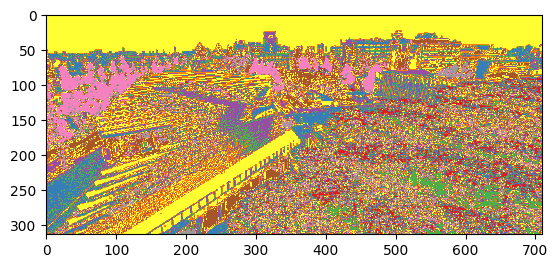

In [34]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(label_matrix, cmap=plt.get_cmap('Set1'))
fig.show()

In [35]:
model.cluster_centers_

array([[125.03813852, 144.64689415,  77.12873778],
       [182.91845075, 184.37283941, 181.61996176],
       [ 42.6820669 ,  57.10355152,  23.86676647],
       [147.86958948, 153.28174811, 142.20815458],
       [213.21481665, 215.97411677, 219.215311  ],
       [101.33866873, 108.74734306, 110.83412934],
       [184.05274033, 137.14867657,  32.83292335],
       [ 84.03345658, 100.12825024,  49.78229365]])

色のRGB値を整数で表示するため、これらのRGB値を整数に丸める。

In [36]:
palette = model.cluster_centers_.astype(int)
palette

array([[125, 144,  77],
       [182, 184, 181],
       [ 42,  57,  23],
       [147, 153, 142],
       [213, 215, 219],
       [101, 108, 110],
       [184, 137,  32],
       [ 84, 100,  49]])

In [37]:
image_decoded = palette[label_matrix]
image_decoded

array([[[213, 215, 219],
        [213, 215, 219],
        [213, 215, 219],
        ...,
        [213, 215, 219],
        [213, 215, 219],
        [213, 215, 219]],

       [[213, 215, 219],
        [213, 215, 219],
        [213, 215, 219],
        ...,
        [213, 215, 219],
        [213, 215, 219],
        [213, 215, 219]],

       [[213, 215, 219],
        [213, 215, 219],
        [213, 215, 219],
        ...,
        [213, 215, 219],
        [213, 215, 219],
        [213, 215, 219]],

       ...,

       [[182, 184, 181],
        [182, 184, 181],
        [147, 153, 142],
        ...,
        [ 84, 100,  49],
        [ 84, 100,  49],
        [125, 144,  77]],

       [[182, 184, 181],
        [182, 184, 181],
        [147, 153, 142],
        ...,
        [ 42,  57,  23],
        [ 42,  57,  23],
        [ 84, 100,  49]],

       [[182, 184, 181],
        [147, 153, 142],
        [147, 153, 142],
        ...,
        [ 42,  57,  23],
        [ 84, 100,  49],
        [ 42,  57,  23]]

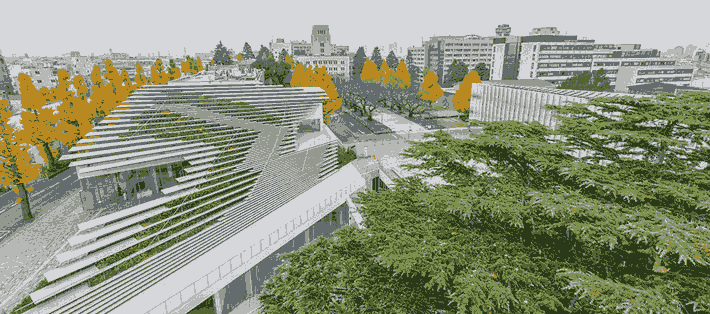

In [38]:
Image.fromarray(np.uint8(image_decoded))

## 確認問題

[教育用標準データセット（SSDSE）](https://www.nstac.go.jp/SSDSE/)に収録されている都道府県庁所在市別・家計消費データ（SSDSE-C）に対してクラスタ分析を適用し、消費行動が類似している都道府県のクラスタを作りたい。

**(1) データセットの読み込み**

このデータセットを読み込み、各都道府県庁所在地を特徴ベクトルで表現せよ。

In [49]:
import urllib
from pathlib import Path
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

URL = "https://www.nstac.go.jp/sys/files//SSDSE-C-2022.csv"

csv = urllib.request.urlopen(URL).read().decode("shift-jis")
csv_path = Path("./ssdse-c-2022.csv")
with csv_path.open(mode="w", encoding="utf-8") as f:
  f.write(csv)


raw_df = pd.read_csv(csv_path)
raw_df.head(5)
code_name = raw_df.iloc[0, :]
df = raw_df.drop(0, axis=0)
location_name = df.iloc[:, :3]
df = df.drop(["Prefecture", "City"], axis=1)
df = df.set_index("SSDSE-C-2022")
df = df.astype("float32")

CATEGORY = "LB12"
feature_df = df[[c for c in df.columns if c.startswith(CATEGORY) and len(c) > len(CATEGORY)]]

feature_df = feature_df.divide(df["LA03"], axis=0)


In [50]:
feature_df.head(5)

,LB121101,LB121102,LB121103,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
SSDSE-C-2022,,,,,,,,,,,,,
R00000,1855.593140,2080.338867,709.830505,4616.949219,6683.389648,1416.610107,3320.000000,2096.271240,1717.627075,14970.847656,2210.847412,3850.169434,3292.542236
R01100,1965.140869,2357.394531,573.943665,5952.816895,8044.014160,1328.169067,5549.647949,2511.267578,1474.295776,7157.042480,1923.239502,5217.253906,4673.591797
R02201,1604.529663,3312.892090,282.926849,4388.153320,4809.059570,957.491333,2367.944336,2018.815430,1390.592407,4934.495117,987.108032,2395.122070,3379.094238
R03201,1747.756470,2740.705322,565.384644,3682.692383,3156.089844,585.256409,1709.294922,1586.859009,1244.871826,11461.218750,1296.794922,3557.692383,3412.500244
R04100,2191.666748,3111.000000,817.333313,4128.000000,5340.666504,963.333313,2513.333252,2024.333374,1528.333374,11679.000000,1699.000000,2665.333252,3059.000000


**(2) WCSSのプロット**

K-meansクラスタリングを異なるクラスタ数$K$で実行し、横軸にクラスタ数、縦軸にK-meansの目的関数の値、すなわちクラスタ内平方和（WCSS: within-cluster sum-of-squares）をプロットしたグラフを描画せよ。

/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/bu

<Axes: >

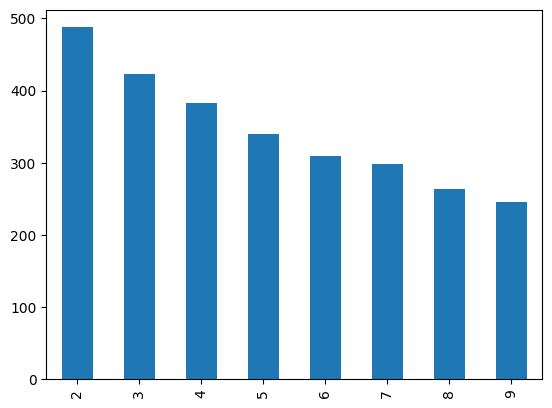

In [51]:
def kmeans(X, n_clusters=3, normalize=True):
  _X = X
  if normalize:
    _X = StandardScaler().fit_transform(X)

  model = KMeans(n_clusters).fit(_X)
  return model


num_clusters = range(2, 10)
models = []
for n_clusters in num_clusters:
  model = kmeans(feature_df, n_clusters=n_clusters, normalize=True)
  models.append(model)

pd.Series(data=[m.inertia_ for m in models], name="wcss", index=list(num_clusters)).plot.bar()


**(3) K-meansクラスタリング**

(2)の結果に基づき、クラスタ数$K$を適当に選び、K-meansクラスタリングを実行せよ。$1$から$K$までの各クラスタに対して、それぞれ所属する都道府県庁所在地を明らかにせよ。

In [52]:
TARGET_CLUSTERS_NUM = 5

In [54]:
model = None
wcss_bar = 0
for trial in range(100):
  _model = kmeans(feature_df, n_clusters=TARGET_CLUSTERS_NUM, normalize=True)
  if model is None or _model.inertia_ < wcss_bar:
    model = _model
    wcss_bar = _model.inertia_

cluster_df = pd.merge(
    feature_df.assign(Cluster=model.labels_),
    location_name.set_index("SSDSE-C-2022"),
    left_index=True, right_index=True)
cluster_df.sort_values("Cluster")[["Cluster", "Prefecture", "City"]]


/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/bu

,Cluster,Prefecture,City
SSDSE-C-2022,,,
R00000,0,全国,全国
R45201,0,宮崎県,宮崎市
R42201,0,長崎県,長崎市
R40130,0,福岡県,福岡市
R38201,0,愛媛県,松山市
R36201,0,徳島県,徳島市
R34100,0,広島県,広島市
R33100,0,岡山県,岡山市
R30201,0,和歌山県,和歌山市


In [58]:
prefecture_counts = cluster_df.groupby(["Cluster", "Prefecture"]).size()
print(prefecture_counts)


Cluster  Prefecture
0        三重県           1
         京都府           1
         全国            1
         兵庫県           1
         和歌山県          1
         大阪府           1
         宮崎県           1
         岡山県           1
         広島県           1
         徳島県           1
         愛媛県           1
         沖縄県           1
         滋賀県           1
         福岡県           1
         長崎県           1
1        北海道           1
         大分県           1
         富山県           1
         山口県           1
         島根県           1
         熊本県           1
         石川県           1
         福井県           1
         長野県           1
         高知県           1
         鳥取県           1
         鹿児島県          1
2        宮城県           1
         山形県           1
         岩手県           1
         新潟県           1
         福島県           1
         秋田県           1
         青森県           1
3        岐阜県           1
         愛知県           1
         東京都           1
         神奈川県          1
4        佐賀県           1
     

In [59]:
unique_prefecture_counts = cluster_df.groupby("Cluster")["Prefecture"].nunique()
print(unique_prefecture_counts)


Cluster
0    15
1    12
2     7
3     4
4    10
Name: Prefecture, dtype: int64
